# Neural Computing and Deep Learning 1402-1 HW04<br>
# **Mohammad Naeimi 401131061**

## Part 0

### imports

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

BATCH_SIZE = 64

## Part 2

### CIFAR10 Dataset

In [48]:
def get_cifar(transform):
    cifar_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    cifar_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_size = int(0.8 * len(cifar_dataset))
    val_size = len(cifar_dataset) - train_size
    cifar_train_dataset, cifar_val_dataset = random_split(cifar_dataset, [train_size, val_size])

    cifar_train_loader = DataLoader(cifar_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    cifar_val_loader = DataLoader(cifar_val_dataset, batch_size=BATCH_SIZE)
    cifar_test_loader = DataLoader(cifar_test_dataset, batch_size=BATCH_SIZE)

    return cifar_train_loader, cifar_val_loader, cifar_test_loader

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
cifar_train_loader, cifar_val_loader, cifar_test_loader = get_cifar(transform)
len(cifar_train_loader), len(cifar_val_loader), len(cifar_test_loader)

Files already downloaded and verified
Files already downloaded and verified


(625, 157, 157)

### Q1

#### Simple Convolutional Neural Network (CNN)

In [49]:
class SimpleCNN(nn.Module):
    def __init__(self, n_channels=32, n_cllassifier=256, kernel_size=3):
        super(SimpleCNN, self).__init__()

        self.n_channels = n_channels
        self.kernel_size = kernel_size
        self.n_cllassifier = n_cllassifier
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

        self.conv1 = nn.Conv2d(3, self.n_channels, kernel_size=self.kernel_size, padding=1)
        self.conv2 = nn.Conv2d(self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=1)
        self.conv3 = nn.Conv2d(self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=1)
        self.conv4 = nn.Conv2d(self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=1)
        self.conv5 = nn.Conv2d(self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(self.n_channels, self.n_cllassifier)
        self.fc2 = nn.Linear(self.n_cllassifier, self.n_cllassifier)
        self.fc3 = nn.Linear(self.n_cllassifier, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.pool(self.relu(self.conv5(x)))
        x = x.view(-1, self.n_channels)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def validate(self, data_loader, verbose=True, p=False):
        self.to(self.device)
        self.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in tqdm(data_loader, desc="Validation", leave=False, disable=not verbose):
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self(images)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        conf_matrix = confusion_matrix(all_labels, all_preds)

        if p:
            print(f'Accuracy: {accuracy * 100:.2f}%')

            plt.figure(figsize=(10, 8))
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()

        return accuracy, conf_matrix

    def train_model(self, train_loader, val_loader, num_epochs=10, lr=0.001, verbose=True):
        self.to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)

        accs = []
        for epoch in range(num_epochs):
            self.train()
            train_loader_iter = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False, disable=not verbose)
            for images, labels in train_loader_iter:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loader_iter.set_postfix(loss=loss.item())
            
            accuracy, _ = self.validate(val_loader, verbose)
            accs += [accuracy]

            if verbose:
                print(f"Epoch {epoch + 1}/{num_epochs} => Val Accuracy: {accuracy * 100:.2f}%")

        return accs

#### Trial & Error

In [47]:
for lr in [0.1, 0.01, 0.001, 0.0001, 0.00001]:
    model = SimpleCNN()
    history = model.train_model(cifar_train_loader, cifar_val_loader, num_epochs=10, verbose=False, lr=lr)
    test_accuracy, conf_matrix = model.validate(cifar_test_loader, verbose=False)
    print(f"Validation Accuracy for lr={lr}: {test_accuracy}")

Validation Accuracy for lr=0.1: 0.1
Validation Accuracy for lr=0.01: 0.404
Validation Accuracy for lr=0.001: 0.7067
Validation Accuracy for lr=0.0001: 0.5053
Validation Accuracy for lr=1e-05: 0.3249


#### Train SimpleCNN

Epoch 1/10:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1/10 => Val Accuracy: 47.07%


Epoch 2/10 => Val Accuracy: 54.82%


Epoch 3/10 => Val Accuracy: 57.51%


Epoch 4/10 => Val Accuracy: 62.69%


Epoch 5/10 => Val Accuracy: 66.14%


Epoch 6/10 => Val Accuracy: 65.68%


Epoch 7/10 => Val Accuracy: 66.60%


Epoch 8/10 => Val Accuracy: 67.24%


Epoch 9/10 => Val Accuracy: 68.07%


Epoch 10/10 => Val Accuracy: 67.11%


Accuracy: 67.18%


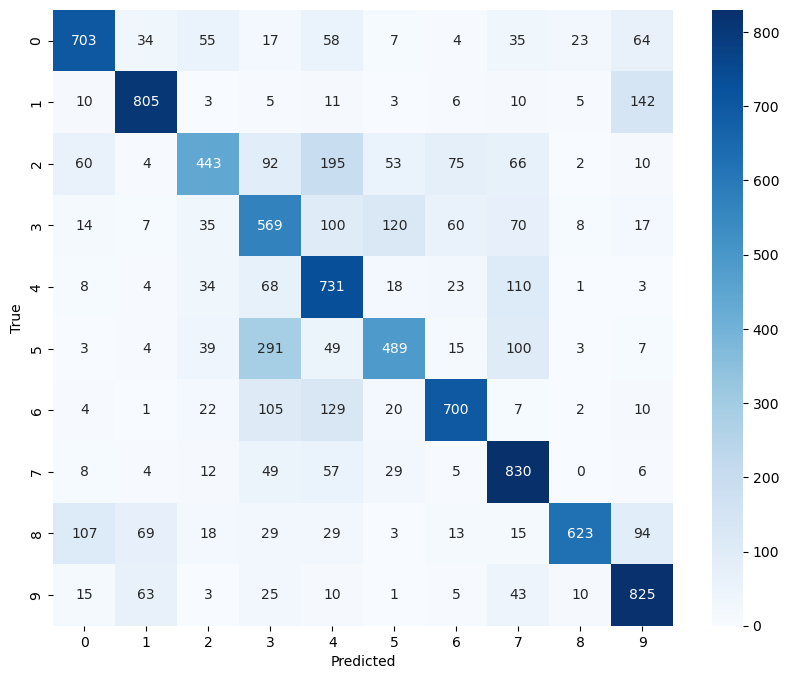

In [50]:
model_p2q1 = SimpleCNN()

history_p2q1 = model_p2q1.train_model(cifar_train_loader, cifar_val_loader, num_epochs=10, lr=0.001)

test_accuracy, conf_matrix = model_p2q1.validate(cifar_test_loader, p=True)

#### Save the model

In [51]:
torch.save(model_p2q1.state_dict(), './model/model_p2q1_cifar10.pth')

### Q2

#### Simple Convolutional Neural Network (CNN) with Residual Connections

In [52]:
class SimpleResCNN(nn.Module):
    def __init__(self, n_channels=32, n_cllassifier=256, kernel_size=3):
        super(SimpleResCNN, self).__init__()

        self.n_channels = n_channels
        self.kernel_size = kernel_size
        self.n_cllassifier = n_cllassifier
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

        self.conv1 = nn.Conv2d(3, self.n_channels, kernel_size=self.kernel_size, padding=1)
        self.conv2 = nn.Conv2d(self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=1)
        self.conv3 = nn.Conv2d(self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=1)
        self.conv4 = nn.Conv2d(self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=1)
        self.conv5 = nn.Conv2d(self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(self.n_channels, self.n_cllassifier)
        self.fc2 = nn.Linear(self.n_cllassifier, self.n_cllassifier)
        self.fc3 = nn.Linear(self.n_cllassifier, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        residual1 = x.detach().clone()
        x = self.pool(self.relu(self.conv2(x) + residual1))
        residual2 = x.detach().clone()
        x = self.pool(self.relu(self.conv3(x) + residual2))
        residual3 = x.detach().clone()
        x = self.pool(self.relu(self.conv4(x) + residual3))
        residual4 = x.detach().clone()
        x = self.pool(self.relu(self.conv5(x) + residual4))
        x = x.view(-1, self.n_channels)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

    def validate(self, data_loader, verbose=True, p=False):
        self.to(self.device)
        self.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in tqdm(data_loader, desc="Validation", leave=False, disable=not verbose):
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self(images)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        conf_matrix = confusion_matrix(all_labels, all_preds)

        if p:
            print(f'Accuracy: {accuracy * 100:.2f}%')

            plt.figure(figsize=(10, 8))
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()

        return accuracy, conf_matrix


    def train_model(self, train_loader, val_loader, num_epochs=10, lr=0.001, verbose=True):
        self.to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)

        accs = []
        for epoch in range(num_epochs):
            self.train()
            train_loader_iter = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False, disable=not verbose)
            for images, labels in train_loader_iter:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loader_iter.set_postfix(loss=loss.item())
            
            accuracy, _ = self.validate(val_loader, verbose)
            accs += [accuracy]

            if verbose:
                print(f"Epoch {epoch + 1}/{num_epochs} => Val Accuracy: {accuracy * 100:.2f}%")

        return accs

#### Run SimpleResCNN

Epoch 1/10 => Val Accuracy: 50.04%


Epoch 2/10 => Val Accuracy: 54.34%


Epoch 3/10 => Val Accuracy: 59.38%


Epoch 4/10 => Val Accuracy: 63.45%


Epoch 5/10 => Val Accuracy: 64.93%


Epoch 6/10 => Val Accuracy: 65.73%


Epoch 7/10 => Val Accuracy: 66.97%


Epoch 8/10 => Val Accuracy: 67.70%


Epoch 9/10 => Val Accuracy: 68.18%


Epoch 10/10 => Val Accuracy: 68.78%


Accuracy: 69.76%


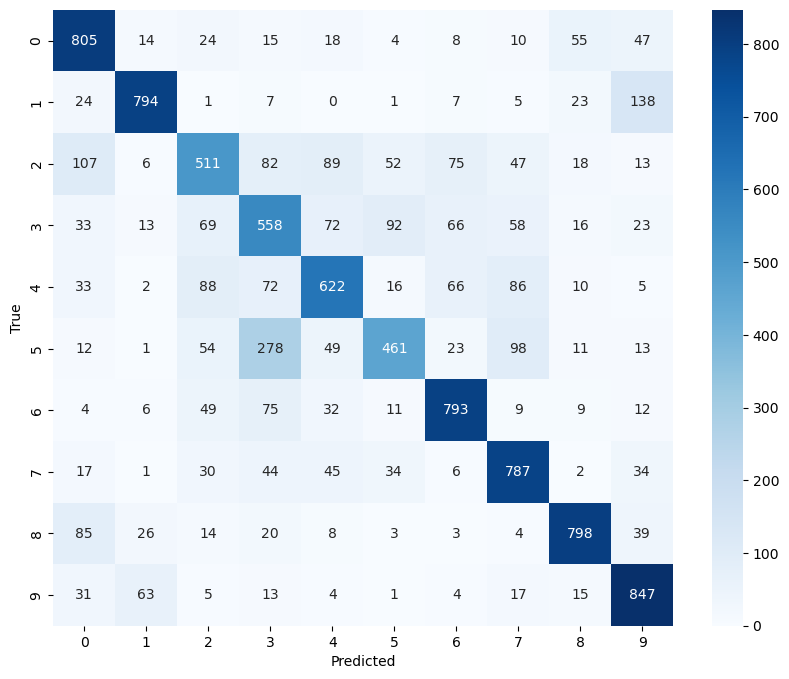

In [53]:
model_p2q2 = SimpleResCNN()

history_p2q2 = model_p2q2.train_model(cifar_train_loader, cifar_val_loader, num_epochs=10, lr=0.001)

test_accuracy, conf_matrix = model_p2q2.validate(cifar_test_loader, p=True)

#### Compare

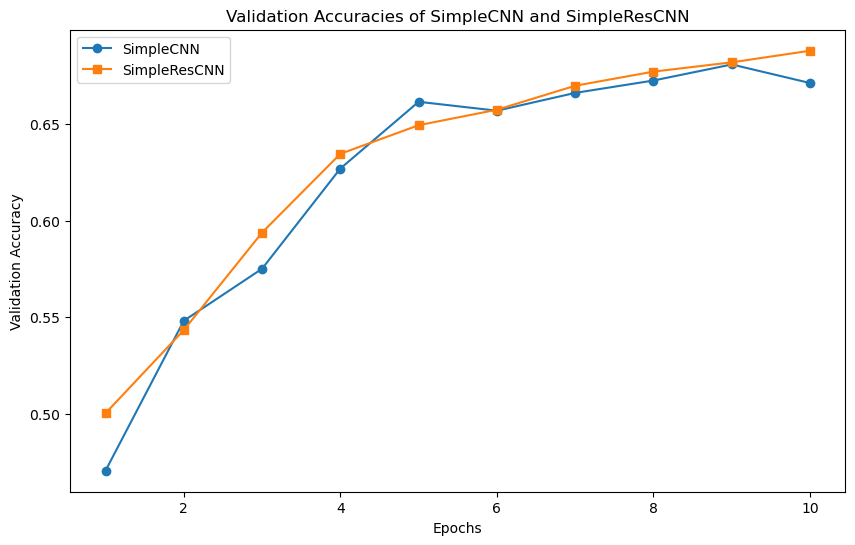

In [54]:
epochs = [i + 1 for i in range(10)]
plt.figure(figsize=(10, 6))
plt.plot(epochs, history_p2q1, label='SimpleCNN', marker='o')
plt.plot(epochs, history_p2q2, label='SimpleResCNN', marker='s')

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracies of SimpleCNN and SimpleResCNN')
plt.legend()
plt.show()

## Part 3

### STL-10 Dataset

In [55]:
def get_stl(transform):
    stl_train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)
    stl_test_dataset = datasets.STL10(root='./data', split='test', download=True, transform=transform)

    full_dataset = torch.utils.data.ConcatDataset([stl_train_dataset, stl_test_dataset])

    train_size = int(0.6 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    val_size = int(0.5 * test_size)
    test_size = test_size - val_size

    stl_train_dataset, stl_val_dataset, stl_test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

    stl_train_loader = DataLoader(stl_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    stl_val_loader = DataLoader(stl_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    stl_test_loader = DataLoader(stl_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return stl_train_loader, stl_val_loader, stl_test_loader

### Q1

Files already downloaded and verified
Files already downloaded and verified
122 41 41


Epoch 1/10 => Val Accuracy: 68.79%


Epoch 2/10 => Val Accuracy: 69.87%


Epoch 3/10 => Val Accuracy: 69.64%


Epoch 4/10 => Val Accuracy: 69.84%


Epoch 5/10 => Val Accuracy: 69.85%


Epoch 6/10 => Val Accuracy: 69.76%


Epoch 7/10 => Val Accuracy: 69.76%


Epoch 8/10 => Val Accuracy: 69.92%


Epoch 9/10 => Val Accuracy: 69.71%


Epoch 10/10 => Val Accuracy: 69.91%


Accuracy: 70.13%


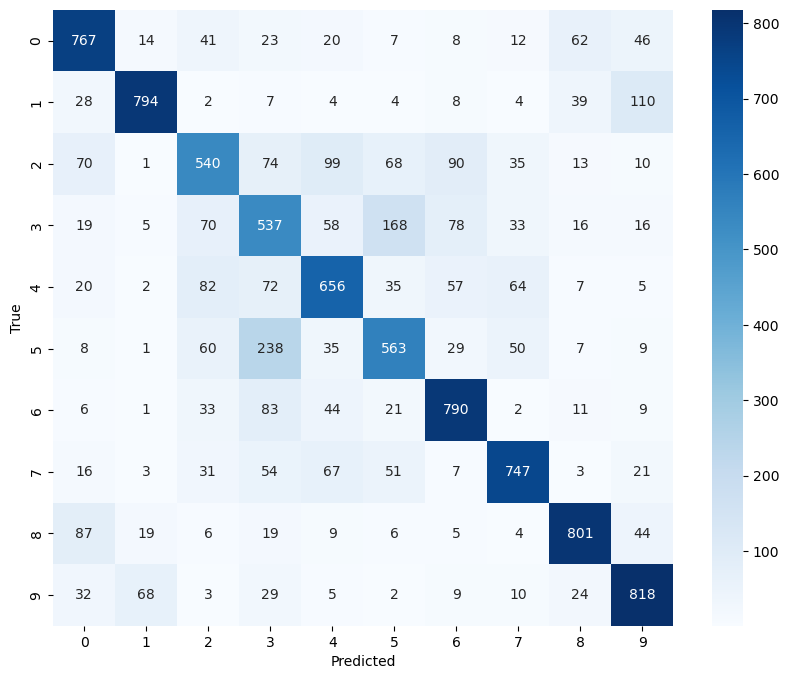

In [56]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32)), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

stl_train_loader, stl_val_loader, stl_test_loader = get_stl(transform)
print(len(stl_train_loader), len(stl_val_loader), len(stl_test_loader))

model_p3q1 = SimpleCNN()
model_p3q1.load_state_dict(torch.load('./model/model_p2q1_cifar10.pth'))
# model_p3q1.eval()

for param in model_p3q1.parameters():
    param.requires_grad = False

model_p3q1.fc1 = nn.Linear(in_features=model_p3q1.n_channels, out_features=model_p3q1.n_cllassifier)
model_p3q1.fc2 = nn.Linear(in_features=model_p3q1.n_cllassifier, out_features=model_p3q1.n_cllassifier)
model_p3q1.fc3 = nn.Linear(in_features=model_p3q1.n_cllassifier, out_features=10)

history_p3q1 = model_p3q1.train_model(cifar_train_loader, cifar_val_loader, num_epochs=10, lr=0.001)

test_accuracy, conf_matrix = model_p3q1.validate(cifar_test_loader, p=True)

### Q2

In [57]:
transform = transforms.Compose([transforms.Resize((299, 299)), transforms.ToTensor()])  # Inception model requires input size of (299, 299)

stl_train_loader, stl_val_loader, stl_test_loader = get_stl(transform)
print(len(stl_train_loader), len(stl_val_loader), len(stl_test_loader))

model_p3q2 = models.inception_v3(pretrained=True)

for param in model_p3q2.parameters():
    param.requires_grad = False

num_classes = 10
model_p3q2.fc = nn.Linear(model_p3q2.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_p3q2 = model_p3q2.to(device)

Files already downloaded and verified
Files already downloaded and verified
122 41 41


c:\ProgramData\Anaconda3\envs\yasin\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\yasin\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10 => Val Accuracy: 95.46%


Epoch 2/10 => Val Accuracy: 95.62%


Epoch 3/10 => Val Accuracy: 95.85%


Epoch 4/10 => Val Accuracy: 96.27%


Epoch 5/10 => Val Accuracy: 95.96%


Epoch 6/10 => Val Accuracy: 96.19%


Epoch 7/10 => Val Accuracy: 96.73%


Epoch 8/10 => Val Accuracy: 96.50%


Epoch 9/10 => Val Accuracy: 96.38%


Epoch 10/10 => Val Accuracy: 96.46%


Accuracy: 95.92%


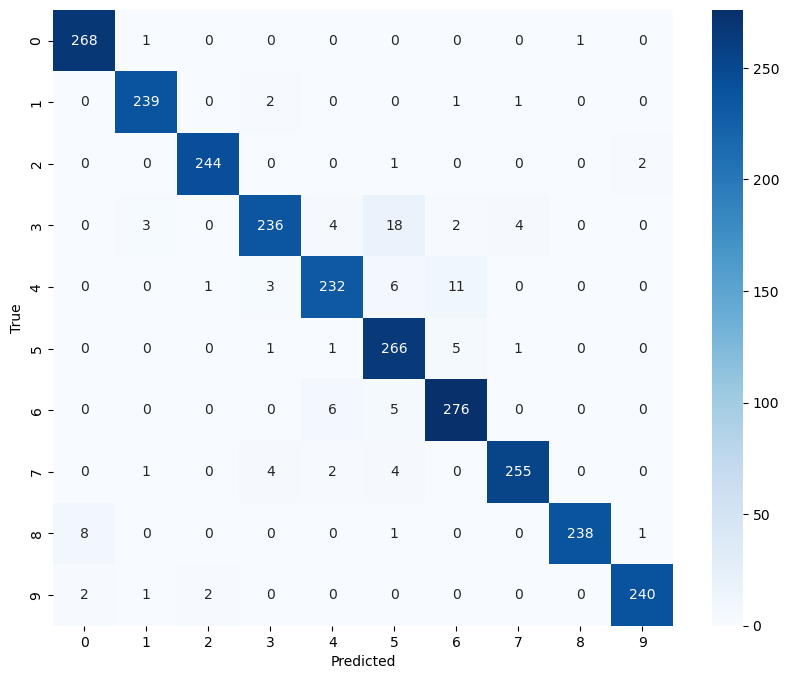

In [58]:
def validate(model, data_loader, device, verbose=True, p=False):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Validation", leave=False, disable=not verbose):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    if p:
        print(f'Accuracy: {accuracy * 100:.2f}%')

        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    return accuracy, conf_matrix

def train_model(model, train_loader, val_loader, device, num_epochs=10, lr=0.001, verbose=True):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    accs = []
    for epoch in range(num_epochs):
        model.train()
        train_loader_iter = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)
        for images, labels in train_loader_iter:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loader_iter.set_postfix(loss=loss.item())
        
        accuracy, _ = validate(model, val_loader, device, verbose)
        accs += [accuracy]

        if verbose:
            print(f"Epoch {epoch + 1}/{num_epochs} => Val Accuracy: {accuracy * 100:.2f}%")

    return accs



history_p3q2 = train_model(model_p3q2, stl_train_loader, stl_val_loader, device, num_epochs=10, lr=0.001)

test_accuracy, conf_matrix = validate(model_p3q2, stl_test_loader, device, p=True)